<a href="https://www.kaggle.com/code/wattuginu/ica-exploration?scriptVersionId=193309371" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICA Exploration Trial

## import library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

## Preprocessing

In [2]:
def preproccesing(df):
    # HFSE
    # La, Ce, Nd, Eu, Gd, Dy, Er, Yb, Th, Nb, Zr, Y
    # LILE
    # Sr, Rb, Ba
    # Create new ratio
    # LILE/LILE
    df["Rb/Sr"] = df["Rb"] / df["Sr"]
    # LILE/HFSE
    df["Ba/Nb"] = df["Ba"] / df["Nb"]
    df["Sr/Y"] = df["Sr"] / df["Y"]
    df["Rb/Yb"] = df["Rb"] / df["Yb"]
    # HFSE/HFSE
    df["Nb/Er"] = df["Nb"] / df["Er"]
    df["Nb/Zr"] = df["Nb"] / df["Zr"]
    df["La/Yb"] = df["La"] / df["Yb"]
    df["Nb/Y"] = df["Nb"] / df["Y"]
    df["Th/Ce"] = df["Th"] / df["Ce"]
    df["Eu/La"] = df["Eu"] / df["La"]
    # Choose important variable
    ratio = [
        "Ba/Nb", "Nb/Zr", "La/Yb", "Sr/Y", "Rb/Sr", "Th/Ce", "Eu/La", "Rb/Yb",
        "Nb/Y", "Nb/Er"
    ]

    frame = [
        "Location", "Longitude", "Latitude", "AGE", "Sample Name", "Island Arc"
    ]
    # Separate the data based on the variable
    ratioData = df[ratio]
    frameData = df[frame]
    # change inf value to nan
    ratioData.loc[:, :] = ratioData.loc[:, :].replace([np.inf, -np.inf], np.nan)
    # Drop Na value
    cleanData = ratioData.dropna(thresh=10)
    zScore = np.abs(st.zscore(cleanData))
    cleanDataZScore = cleanData[(zScore < 3).all(axis=1)]
    # concat kedua dataframe
    concatData = pd.concat([cleanDataZScore, frameData], axis=1, join='inner')
    concatData.reset_index(drop=True, inplace=True)
    concatData.to_csv('10_rasio_trace_element.csv')
    preprocessingData = concatData[ratio]
    
    return preprocessingData, concatData, frame, ratio
    
df = pd.read_csv("/kaggle/input/geochemistry/Dataset.csv")

preprocessingData, concatData, frame, ratio = preproccesing(df)

In [3]:
preprocessingData

,Ba/Nb,Nb/Zr,La/Yb,Sr/Y,Rb/Sr,Th/Ce,Eu/La,Rb/Yb,Nb/Y,Nb/Er
0,205.093834,0.016993,3.601266,30.612245,0.038000,0.062174,0.161863,10.822785,0.050748,0.438824
1,178.761062,0.017574,3.860577,26.979167,0.035135,0.066321,0.136986,8.750000,0.058854,0.511312
2,80.691643,0.021159,2.198433,8.080808,0.091250,0.087940,0.171021,5.718016,0.116835,0.940379
3,120.000000,0.020315,3.169611,15.740741,0.039529,0.067485,0.128205,5.936396,0.057407,0.534483
4,150.961538,0.023744,3.564972,27.312500,0.048055,0.070199,0.150872,11.864407,0.065000,0.550265
...,...,...,...,...,...,...,...,...,...,...
132,109.310345,0.024370,6.116838,12.183099,0.112717,0.170604,0.078090,13.402062,0.102113,1.115385
133,102.500000,0.026954,5.789474,17.489177,0.049505,0.130252,0.100909,10.526316,0.086580,1.052632
134,82.000000,0.024752,4.881517,12.727273,0.077922,0.132780,0.091262,11.374408,0.103306,1.136364
135,91.153846,0.024299,4.854369,13.562753,0.086567,0.130612,0.094000,14.077670,0.105263,1.368421


In [4]:
def transformer(preprocessingData, transformer):
    if transformer == 1:
        tranformedData = StandardScaler().fit_transform(preprocessingData)
        transformatorName = "StandardScaler"
    if transformer == 2:
        tranformedData = PowerTransformer().fit_transform(preprocessingData)
        transformatorName = "PowerTransformerY"
    if transformer == 3:
        tranformedData = PowerTransformer(method="box-cox").fit_transform(preprocessingData)
        transformatorName = "PowerTransformerB"
    if transformer == 4:
        tranformedData = Normalizer().fit_transform(preprocessingData)
        transformatorName = "Normalizer"
    if transformer == 5:
        tranformedData = RobustScaler().fit_transform(preprocessingData)
        transformatorName = "RobustScaler"
    if transformer == 6:
        tranformedData = QuantileTransformer().fit_transform(preprocessingData)
        transformatorName = "QuantileTransformerU"
    if transformer == 7:
        tranformedData = QuantileTransformer(
            output_distribution="normal").fit_transform(preprocessingData)
        transformatorName = "QuantileTransformerN"
        
    return tranformedData, transformatorName

tranformedData, transformatorName = transformer(preprocessingData, 3)

## PCA

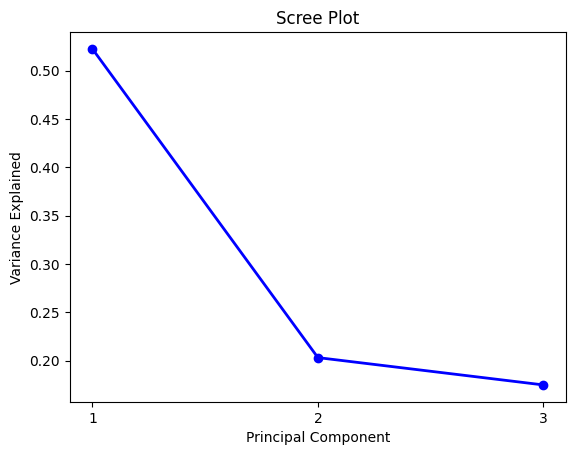

Principal Components: 
 [[6.19484718e-04 2.68522746e-01 3.95868737e-01 2.31289842e-01
  1.54772715e-01 2.64455454e-01 4.09405492e-01 3.53703142e-01
  4.06839759e-01 4.06889989e-01]
 [3.61146135e-01 4.37654901e-01 6.90350158e-02 2.19929746e-01
  5.69896590e-01 3.79494469e-01 3.84301254e-02 3.28306124e-01
  1.57111332e-01 1.48838164e-01]
 [6.23947240e-01 2.37143611e-01 2.35477459e-01 5.46668523e-01
  2.79520846e-01 2.70266051e-01 8.90236679e-02 8.00356347e-02
  1.07865417e-01 1.51707403e-01]]
Explained Variance Ratio: 
 [0.5225049  0.20316463 0.17490212]
Loading Vectors: 
 [[ 0.00142124  0.51665168  0.82820193]
 [-0.61605161 -0.62610428 -0.31477469]
 [-0.90821197 -0.09876073  0.3125631 ]
 [-0.53063094 -0.31462907  0.72562534]
 [-0.35508344  0.81528779 -0.37102449]
 [-0.60672032  0.54290061 -0.35874005]
 [ 0.93926833 -0.05497771 -0.11816636]
 [-0.8114746   0.46967113  0.10623601]
 [-0.93338196 -0.22476174 -0.14317612]
 [-0.9334972  -0.21292624 -0.20137017]]


In [5]:
def pc(tranformedData, numberOfComponent, concatData, frame, ratio, transformatorName):
    # fitting
    pca = PCA(n_components=numberOfComponent, whiten=True)
    principalComponent = pca.fit_transform(tranformedData)
    
    # Explained variance
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values,
             pca.explained_variance_ratio_,
             'o-',
             linewidth=2,
             color='blue')
    plt.title('Scree Plot')
    plt.xticks([x for x in range(1, numberOfComponent+1)])
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()
    
    # Components
    principalComponents = abs(pca.components_)
    print("Principal Components: \n", principalComponents)
    
    explainedVarianceRatio = pca.explained_variance_ratio_
    print("Explained Variance Ratio: \n", explainedVarianceRatio)
    
    loadingVectors = pca.components_.T * np.sqrt(pca.explained_variance_)
    print("Loading Vectors: \n", loadingVectors)
    
    principalComponentsData = pd.DataFrame(data=principalComponent, columns=['PC1', 'PC2', 'PC3'])
    principalComponentsDataframe = pd.concat([principalComponentsData, concatData[frame]], axis=1)
    principalComponentsDataframe.to_csv(f"TraceElement_PCA_{numberOfComponent}_{transformatorName}.csv")
    
    return principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio
    
numberOfComponent = 3
principalComponentsDataframe, principalComponent, loadingVectors, explainedVarianceRatio = pc(tranformedData, numberOfComponent, concatData, frame, ratio, transformatorName)

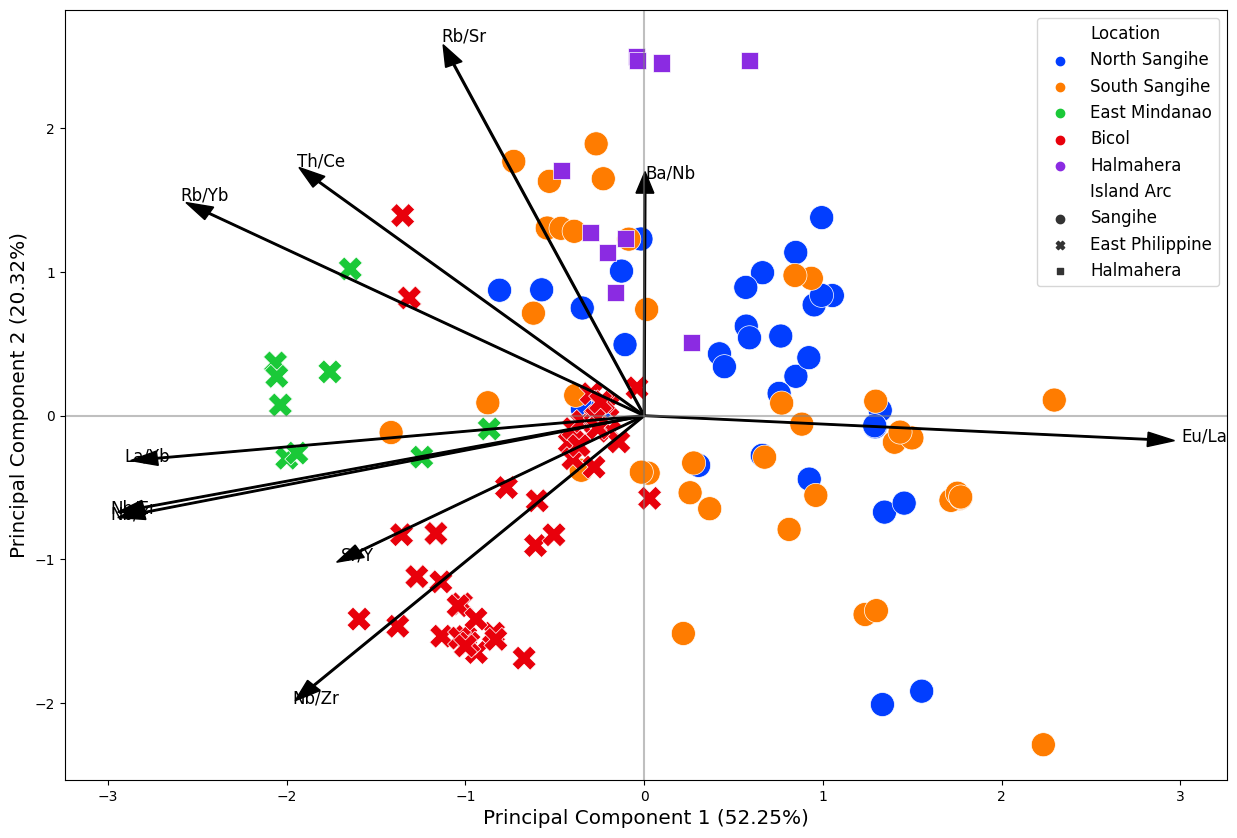

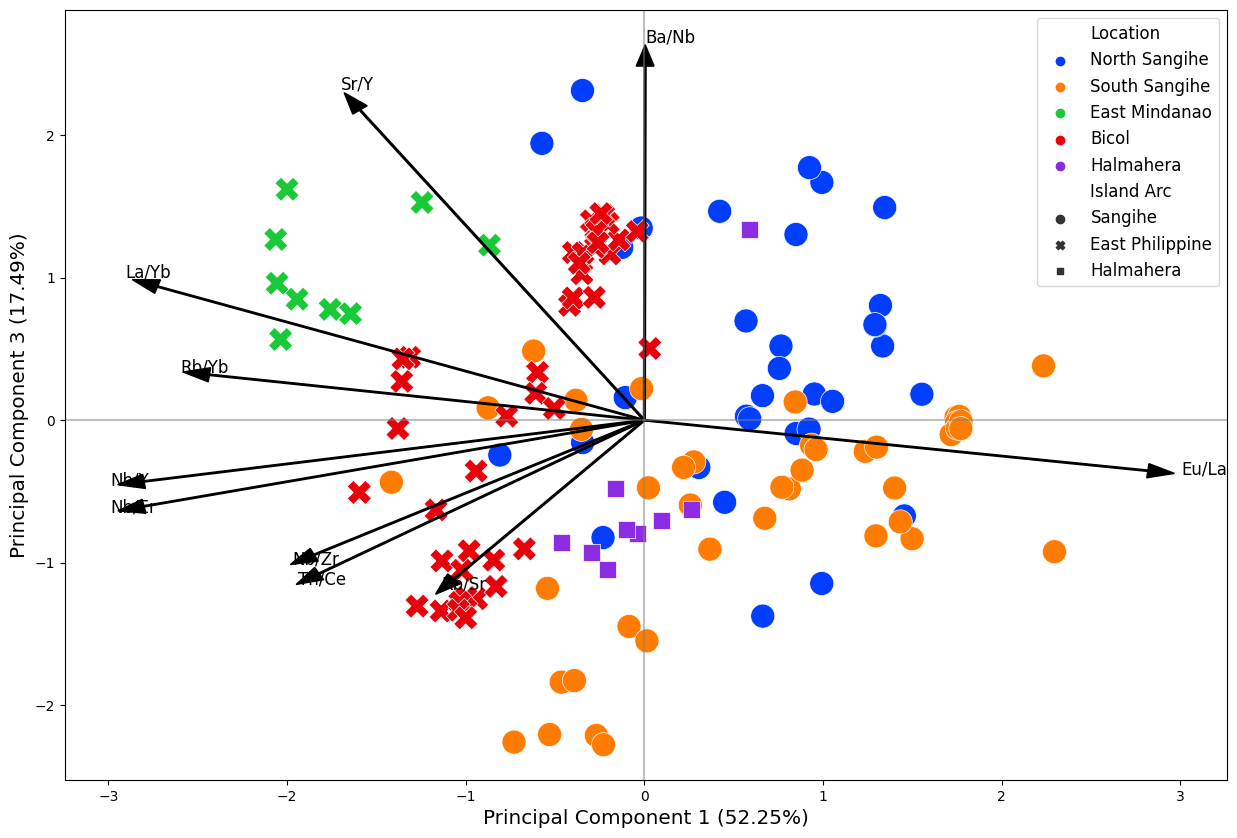

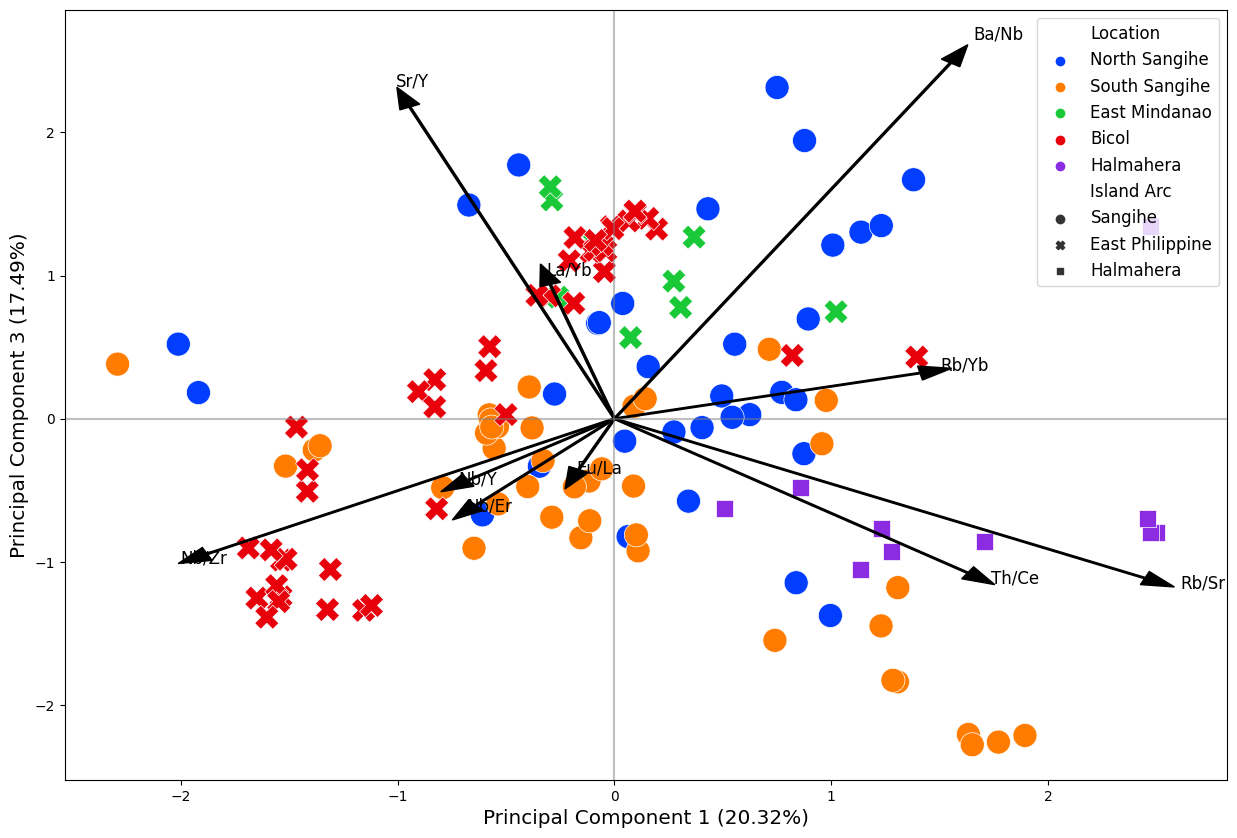

In [6]:
# PC1vsPC2
fig1, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 2 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(ratio):
    plt.arrow(0,
              0,  
              3 * loadingVectors[i, 0],
              3 * loadingVectors[i, 1],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(3.2 * loadingVectors[i, 0],
             3.2 * loadingVectors[i, 1],
             feature,
             fontsize="large")
plt.savefig(f'PCA_trace_{transformatorName}_1vs2.svg')

# PC1vsPC3
fig2, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC1",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[0]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(ratio):
    plt.arrow(0,
              0,  
              3 * loadingVectors[i, 0],
              3 * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(3.2 * loadingVectors[i, 0],
             3.2 * loadingVectors[i, 2],
             feature,
             fontsize="large")
plt.savefig(f'PCA_trace_{transformatorName}_1vs3.svg')

# PC2vsPC3
fig3, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=principalComponentsDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="PC2",
                y="PC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")

plt.legend(fontsize="large", loc=1)
plt.xlabel(f'Principal Component 1 ({explainedVarianceRatio[1]*100:.2f}%)', fontsize="x-large")
plt.ylabel(f'Principal Component 3 ({explainedVarianceRatio[2]*100:.2f}%)', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
for i, feature in enumerate(ratio):
    plt.arrow(0,
              0,  
              3 * loadingVectors[i, 1],
              3 * loadingVectors[i, 2],
              color='black',
              width=0.01,
              head_width=0.1)
    plt.text(3.2 * loadingVectors[i, 1],
             3.2 * loadingVectors[i, 2],
             feature,
             fontsize="large")
plt.savefig(f'PCA_trace_{transformatorName}_2vs3.svg')

## ICA

In [7]:
def ic(whitenedData, concatData, frame):
    ica = FastICA(whiten= False, max_iter=10000)
    icaData = ica.fit_transform(whitenedData)
    icaIndependentComponent = pd.DataFrame(data=icaData, columns=['IC1', 'IC2', 'IC3'])
    icaDataframe = pd.concat([icaIndependentComponent, concatData[frame]], axis=1)
    
    return icaIndependentComponent, icaDataframe

icaIndependentComponent, icaDataframe = ic(principalComponent, concatData, frame)

In [8]:
icaIndependentComponent

,IC1,IC2,IC3
0,-0.242675,1.469759,1.858688
1,-0.171961,1.239151,1.464448
2,1.242154,1.055645,-0.813713
3,0.120816,1.190130,0.320663
4,0.079185,0.891455,0.897647
...,...,...,...
132,1.921474,0.348691,0.224775
133,0.962836,0.241530,0.056565
134,1.498807,0.331286,-0.277909
135,1.575568,0.309627,-0.084928


In [9]:
icaDataframe

,IC1,IC2,IC3,Location,Longitude,Latitude,AGE,Sample Name,Island Arc
0,-0.242675,1.469759,1.858688,North Sangihe,125.800,4.500,PLIOCENE [16735],s_PJ-40-78 [16735],Sangihe
1,-0.171961,1.239151,1.464448,North Sangihe,125.700,4.233,PLIOCENE [16735],s_PJ-43-78 [16735],Sangihe
2,1.242154,1.055645,-0.813713,North Sangihe,125.716,3.866,PLIOCENE [16735],s_PJ-45-78 [16735],Sangihe
3,0.120816,1.190130,0.320663,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PBUANG [16735],Sangihe
4,0.079185,0.891455,0.897647,North Sangihe,125.583,3.783,PLIOCENE [16735],s_PJ-5-78 [16735],Sangihe
...,...,...,...,...,...,...,...,...,...
132,1.921474,0.348691,0.224775,Halmahera,127.330,0.800,NaN,s_GL [25001],Halmahera
133,0.962836,0.241530,0.056565,Halmahera,127.350,0.300,NaN,s_MK1 [25001],Halmahera
134,1.498807,0.331286,-0.277909,Halmahera,127.350,0.300,NaN,s_MK2 [25001],Halmahera
135,1.575568,0.309627,-0.084928,Halmahera,127.350,0.300,NaN,s_MK3 [25001],Halmahera


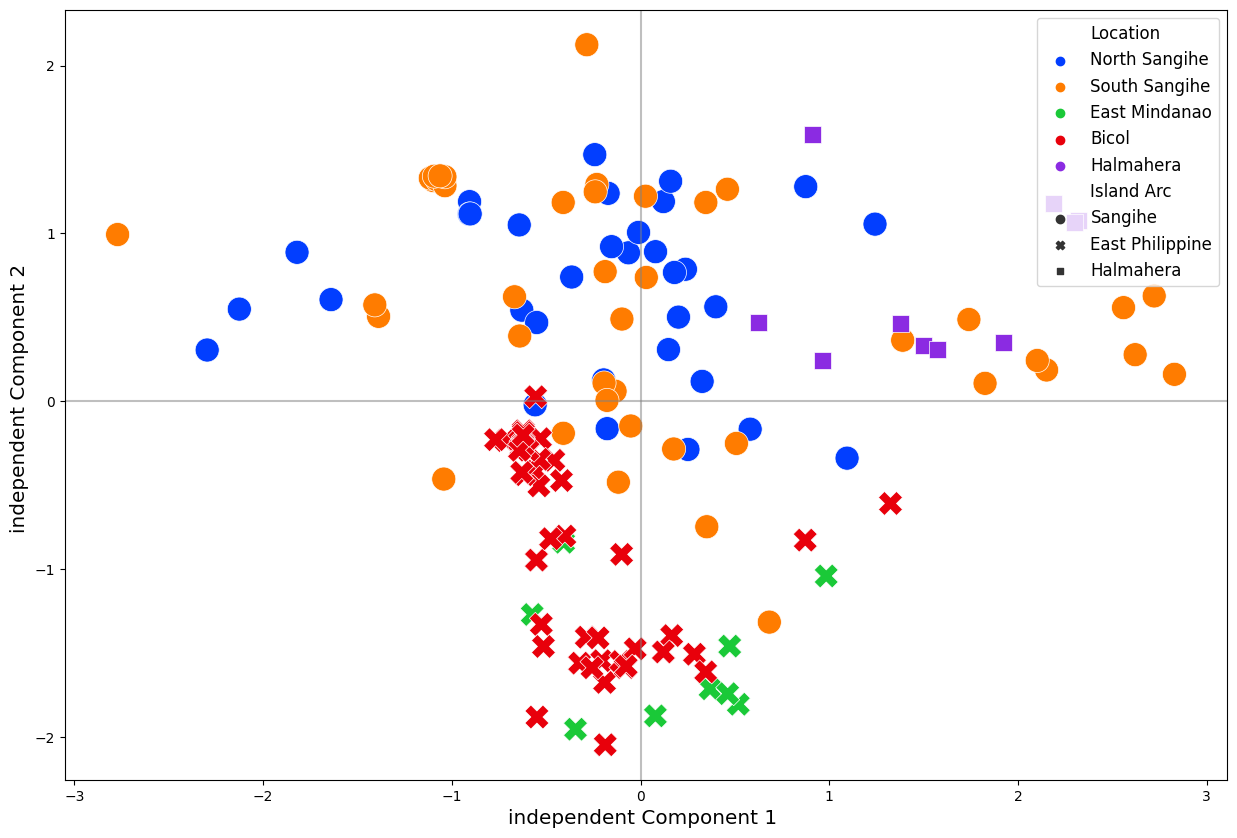

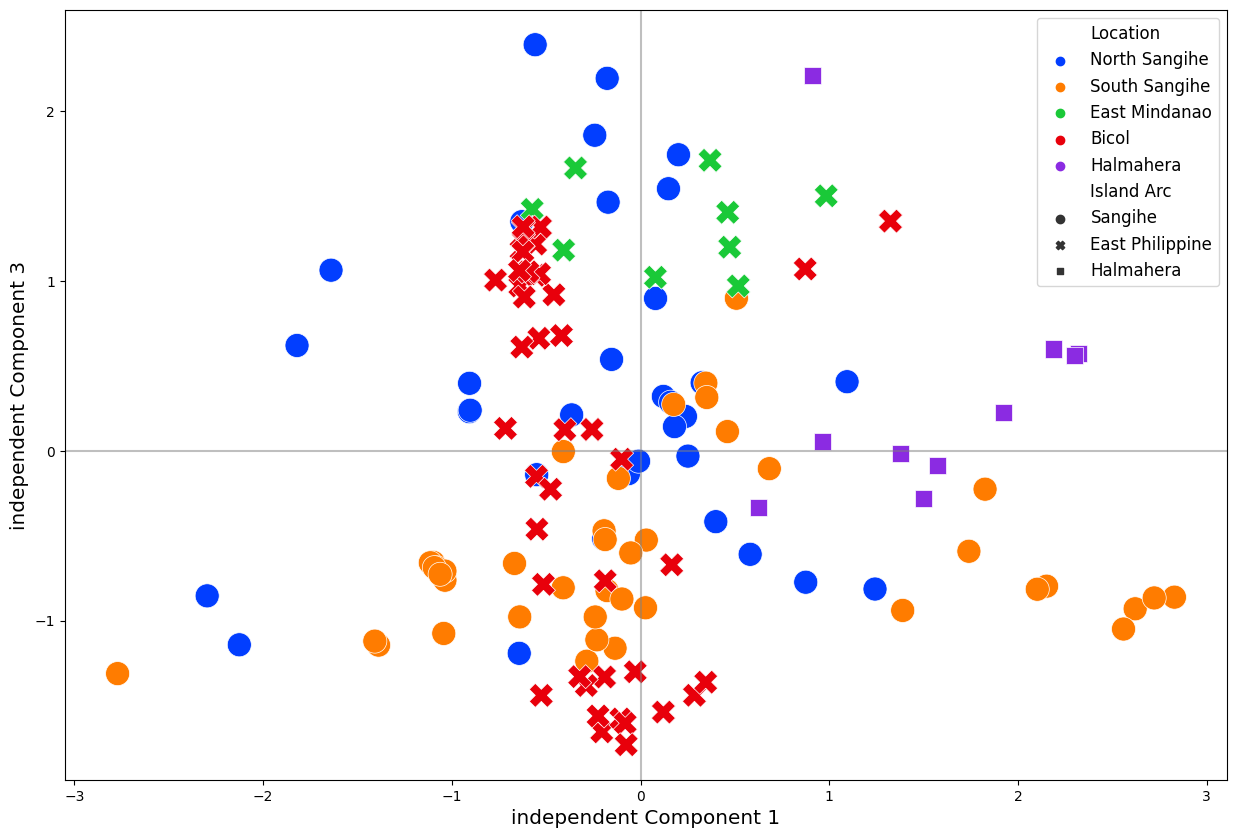

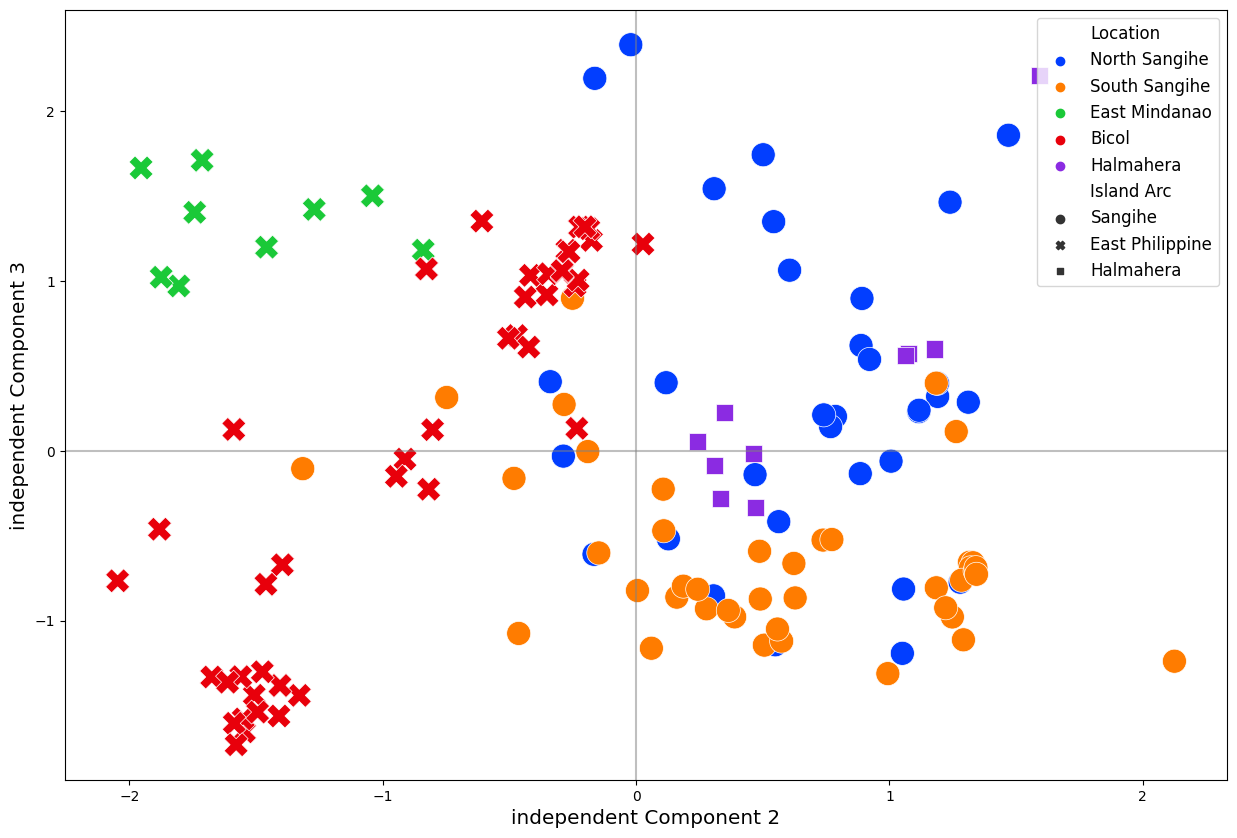

In [10]:
# IC1vsIC2
figx, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=icaDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC2",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1 ', fontsize="x-large")
plt.ylabel(f'independent Component 2 ', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{transformatorName}_1vs2.svg')
# IC1vsIC3
figy, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=icaDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="IC1",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 1', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{transformatorName}_1vs3.svg')
# IC2vsIC3
figz, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=icaDataframe,
                edgecolors="black",
                linewidth=0.5,
                x="IC2",
                y="IC3",
                s=300,
                palette='bright',
                hue="Location",
                style="Island Arc")
plt.legend(fontsize="large", loc=1)
plt.xlabel(f'independent Component 2', fontsize="x-large")
plt.ylabel(f'independent Component 3', fontsize="x-large")
ax.axhline(y=0, color='gray', alpha=0.5)
ax.axvline(x=0, color='gray', alpha=0.5)
plt.savefig(f'ICA_trace_{transformatorName}_2vs3.svg')

## KCA

### PCA

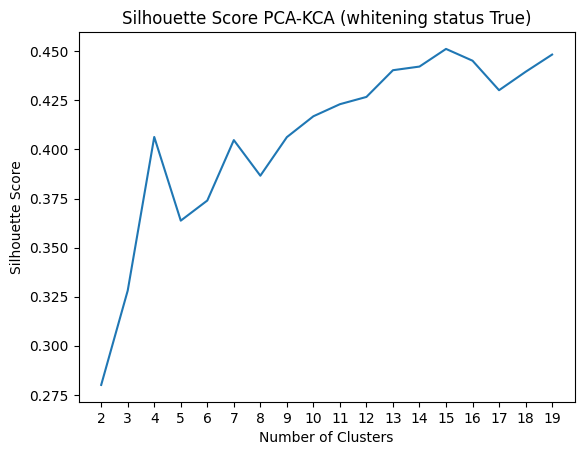

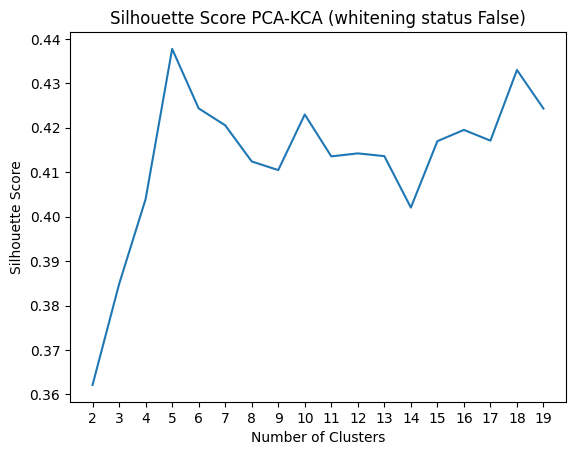

In [11]:
def pcaKca(df, whitenStatus):
    x = df.iloc[:, 0:10].values
    sc = []
    K = range(2, 20)
    for k in K:
        # Building and fitting the model
        # create pipeline for preprocessor
        preprocessor = Pipeline([("scaler", PowerTransformer(method="box-cox")),
                                 ("pca", PCA(n_components=3,
                                             whiten=whitenStatus,
                                             random_state=12))])
        # create pipeline for clusterer
        clusterer = Pipeline([("kca",
                               KMeans(n_clusters=k,
                                      init="k-means++",
                                      n_init=50,
                                      max_iter=500,
                                      random_state=42))])
        # membuat pipeline untuk fitting
        pipe = Pipeline([("preprocessor", preprocessor),
                         ("clusterer", clusterer)])
        # Data Lengkap
        pipe.fit_predict(x)
        pra = pipe["preprocessor"].transform(x)
        pasca = pipe.fit_predict(x)
        score = silhouette_score(pra, pasca, metric="euclidean")
        sc.append(score)
    figx, ax = plt.subplots()
    plt.plot(K, sc)
    plt.xticks(np.arange(2, 20, 1.0))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f"Silhouette Score PCA-KCA (whitening status {whitenStatus})")
    plt.savefig(f"silhouette score PCA-KCA (whitening status {whitenStatus}).svg")
    
pcaKca(preprocessingData, True)
pcaKca(preprocessingData, False)

### ICA

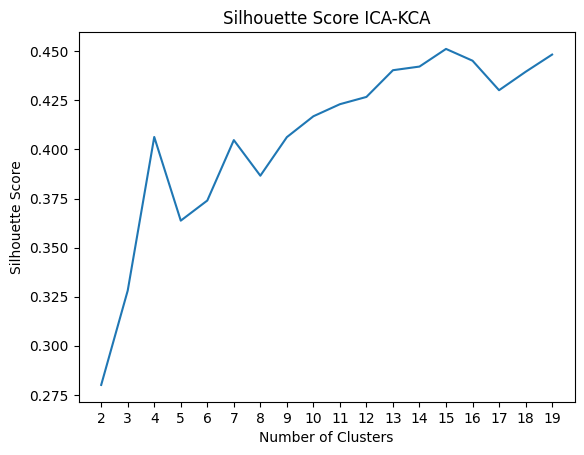

In [12]:
def icaKca(df):
    x = df.iloc[:, 0:10].values
    sc = []
    K = range(2, 20)
    for k in K:
        # Building and fitting the model
        # create pipeline for preprocessor
        preprocessor = Pipeline([("scaler", PowerTransformer(method="box-cox")),
                                 ("pca", PCA(n_components=3,
                                             whiten=True,
                                             random_state=12)),
                                 ("ica", FastICA(whiten= False, max_iter=10000))])
        # create pipeline for clusterer
        clusterer = Pipeline([("kca",
                               KMeans(n_clusters=k,
                                      init="k-means++",
                                      n_init=50,
                                      max_iter=500,
                                      random_state=42))])
        # membuat pipeline untuk fitting
        pipe = Pipeline([("preprocessor", preprocessor),
                         ("clusterer", clusterer)])
        # Data Lengkap
        pipe.fit_predict(x)
        pra = pipe["preprocessor"].transform(x)
        pasca = pipe.fit_predict(x)
        score = silhouette_score(pra, pasca, metric="euclidean")
        sc.append(score)
    figx, ax = plt.subplots()
    plt.plot(K, sc)
    plt.xticks(np.arange(2, 20, 1.0))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title("Silhouette Score ICA-KCA")
    plt.savefig("silhouette score ICA-KCA.svg")
    
icaKca(preprocessingData)